# Analysis of the first round of requests

Import the necessary packages:

In [1]:
import re
import os
import json
import random
import requests
import joblib
import pickle
import pandas as pd
import numpy as np

# SQLite
import sqlite3

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Train-test split and Grid Search
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Feature Engine
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
                              f1_score, classification_report, precision_recall_curve,
                              confusion_matrix )

# Utils
from utils import *

Read the data, and create a copy of it:

In [2]:
df = pd.read_csv('data/first_batch_requests_data.csv')
df_ = df.copy(deep = True)

df_test = pd.read_csv('data/test_data.csv')
df_test_ = df_test.copy(deep = True)

y_pred_proba_test = pickle.load(open("data/y_pred_predictions.pickle", "rb"))
y_pred_test = pickle.load(open("data/y_pred_test.pickle", 'rb'))

Fill '?' values with NaN:

In [3]:
df_ = df_.replace('?', np.nan)

Check the number of observations for which actual values were provided:

Check the number of distinct patients in the data:

In [4]:
df_['patient_id'].nunique()

9036

In [5]:
df_['actual_readmitted'].value_counts(dropna = False, normalize = True)

No     0.886924
Yes    0.113076
Name: actual_readmitted, dtype: float64

Get the bar plot:

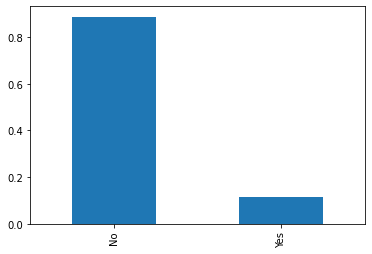

In [6]:
df_['actual_readmitted'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

Get just the real values and predictions:

In [7]:
predictions = df_['predicted_readmitted'].apply(lambda x: 1 if x == 'Yes' else 0)
proba = df_['probability']
actual = df_['actual_readmitted'].apply(lambda x: 1 if x == 'Yes' else 0)

actual_test = df_test_['readmitted']

Drop unnecessary columns:

In [8]:
df_ = df_.drop(columns = ['id', 'index', 'predicted_readmitted', 'probability', 'actual_readmitted'])
df_.head()

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,number_diagnoses,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed
0,83971.0,47195552.0,Caucasian,Female,[80-90),NaN,1.0,3.0,17.0,2.0,...,7.0,A+,12.8,False,Norm,None,No,No,No,Yes
1,91295.0,46828960.0,Caucasian,Male,[30-40),NaN,1.0,1.0,7.0,3.0,...,6.0,A+,16.0,False,None,None,No,Yes,Ch,Yes
2,100312.0,47047376.0,Caucasian,Female,[60-70),NaN,1.0,1.0,17.0,1.0,...,6.0,A+,12.6,False,NORM,None,No,No,Ch,Yes
3,88315.0,146340.0,Caucasian,Female,[70-80),NaN,1.0,13.0,7.0,11.0,...,9.0,B+,13.8,False,NONE,None,No,Yes,Ch,Yes
4,100706.0,12224646.0,Caucasian,Male,[40-50),NaN,2.0,1.0,1.0,3.0,...,5.0,A+,14.2,False,None,>8,No,Yes,No,Yes


Checking for problems concerning the same patients:

In [27]:
repeated_patients = df_["patient_id"].value_counts()[df_["patient_id"].value_counts() > 1].index.to_list()

static_cols = ['race',
               'gender',
               'age',
               'blood_type']

race_problems = []
gender_problems = []
age_problems = []
blood_type_problems = []

for col in static_cols:
    data_quality_errors = 0
    
    for patient in repeated_patients:
        value_counts = df_[df_["patient_id"] == patient][col].value_counts().values
        
        if len(value_counts) > 1:
            data_quality_errors += 1
            
            if col == 'race':
                race_problems.append(patient)
            elif col == 'gender':
                gender_problems.append(patient)
            elif col == 'age':
                age_problems.append(patient)
            else:
                blood_type_problems.append(patient)
    
    print(f'Column: {col}; issues detected: {data_quality_errors}')

Column: race; issues detected: 5
Column: gender; issues detected: 1
Column: age; issues detected: 31
Column: blood_type; issues detected: 309


In [36]:
df_[df_['patient_id'] == gender_problems[0]]

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,number_diagnoses,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed
415,83990.0,81735280.0,caucasian,Male,[40-50),NaN,1.0,1.0,7.0,3.0,...,6.0,O+,16.0,False,NONE,None,No,Yes,Ch,Yes
7906,81730.0,81735280.0,caucasian,Female,[40-50),NaN,1.0,5.0,7.0,2.0,...,9.0,A+,13.5,False,None,None,No,Yes,Ch,Yes


Import the pipeline, column types:

In [9]:
directory = '/home/pgomes/projects/model-deployment/ldssa_capstone_project'

with open(f'{directory}/columns.json') as fh:
    columns = json.load(fh)

with open(f'{directory}/pipeline.pickle', 'rb') as fh:
    pipeline = joblib.load(fh)

with open(f'{directory}/dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

Compare the real values with the predictions:

In [10]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      8424
           1       0.17      0.53      0.26      1074

    accuracy                           0.66      9498
   macro avg       0.55      0.61      0.52      9498
weighted avg       0.84      0.66      0.72      9498



Print the confusion matrix:

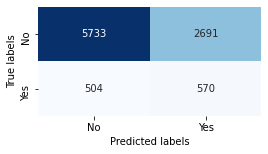

In [11]:
cm = confusion_matrix(actual, predictions)

plt.figure(figsize = (4, 2))

ax = plt.subplot()
sns.heatmap(cm, annot = True, 
            fmt = 'g', 
            cmap = 'Blues',
            ax = ax, cbar = False ); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);

In [12]:
# Test Data
print(roc_auc_score(actual_test, y_pred_proba_test))

# New Data
print(roc_auc_score(actual, proba))

0.6623693372356807
0.655568144841112


Plot ROC:

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.656
Test data: ROC AUC=0.662


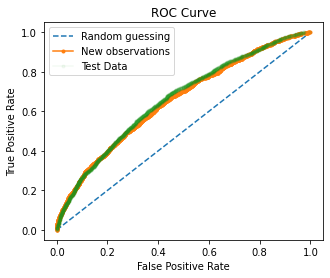

In [13]:
ns_probs = [0 for _ in range(df_.shape[0])]

# calculate scores
ns_auc = roc_auc_score(actual, ns_probs)
lr_auc = roc_auc_score(actual, proba)
ts_auc = roc_auc_score(actual_test, y_pred_proba_test)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Test data: ROC AUC=%.3f' % (ts_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(actual, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(actual, proba)
ts_fpr, ts_tpr, _ = roc_curve(actual_test, y_pred_proba_test)

plt.figure(figsize = (5, 4))

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'Random guessing')
plt.plot(lr_fpr, lr_tpr, marker='.', label = 'New observations')
plt.plot(ts_fpr, ts_tpr, marker='.', label = 'Test Data', alpha = 0.05)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the title
plt.title('ROC Curve')

# show the plot
plt.show()

Precision-Recall curves:

In [14]:
precision_ts, recall_ts, thresholds_ts = precision_recall_curve(actual_test, y_pred_proba_test)

precision_ts = precision_ts[:-1]
recall_ts = recall_ts[:-1]

precision, recall, thresholds = precision_recall_curve(actual, proba)

precision = precision[:-1]
recall = recall[:-1]

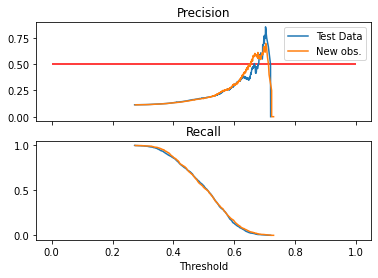

In [15]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.hlines(y = 0.5, xmin = 0, xmax = 1, colors = 'red')

ax1.plot(thresholds_ts, precision_ts)
ax1.plot(thresholds, precision)

ax2.plot(thresholds_ts, recall_ts)
ax2.plot(thresholds, recall)

ax1.get_shared_x_axes().join(ax1, ax2)

ax1.set_xticklabels([])
plt.xlabel('Threshold')

ax1.legend(['Test Data', 'New obs.'])

ax1.set_title('Precision')
ax2.set_title('Recall')

plt.show()

Correlation:

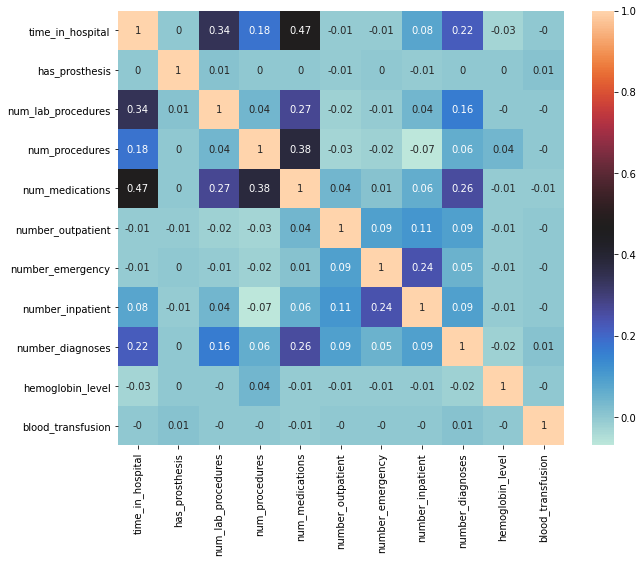

In [16]:
cols_to_drop = ['admission_id', 
                'patient_id', 
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code']

corr = np.round(df_.drop(columns = cols_to_drop).corr(), 2)

plt.figure(figsize = (10,8))

sns.heatmap(corr, 
            cmap = 'icefire', 
            annot = True,
            # xticklabels = labels,
            # yticklabels = labels
           )

plt.show()

Compare the differences between the sets:

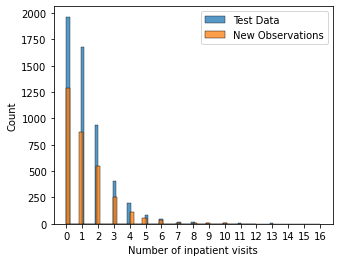

In [17]:
plt.figure(figsize = (5, 4))

differences_test = df_test_[(actual_test != y_pred_test)]['number_inpatient']
differences_new = df_[predictions != actual]['number_inpatient']

sns.histplot(differences_test, kde = False, color = 'C0')
sns.histplot(differences_new, kde = False, color = 'C1')

# plt.axvline(x = differences_test.median(), color = 'k')
#plt.axvline(x = differences_new.median(), color = 'r')

plt.legend(['Test Data', 'New Observations'])

plt.xlabel('Number of inpatient visits')
plt.xticks(np.arange(0, 17, 1))

plt.show()

## Discrimination analysis:

In [18]:
def verify_descrimination(X_test, 
                          y_test, 
                          y_pred, 
                          max_diff = 0.10,
                          min_percent = 0.01,
                          sensitive_column = 'gender'):

    sensitive_classes = X_test[sensitive_column].unique()
    min_samples = X_test.shape[0]*min_percent
    
    is_satisfied = True
    recalls = {}
    
    for sensitive_class in sensitive_classes:
        mask = X_test[sensitive_column] == sensitive_class
        
        if mask.sum() > min_samples:
            recalls[sensitive_class] = recall_score(y_test[mask], y_pred[mask])

    diff = np.max(list(recalls.values())) - np.min(list(recalls.values()))
    
    if diff > max_diff:
        is_satisfied = False

    return is_satisfied, diff, recalls

Gender:

In [19]:
verify_descrimination(df_, actual, predictions, sensitive_column = 'gender')

(True,
 0.04742470315920311,
 {'Female': 0.5524956970740104, 'Male': 0.5050709939148073})

Age:

In [20]:
df_['age'].value_counts(normalize = True)*100

[70-80)     26.308360
[60-70)     22.540717
[50-60)     17.024973
[80-90)     15.928339
[40-50)      9.695983
[30-40)      3.593920
[90-100)     2.616721
[20-30)      1.552660
[10-20)      0.629750
[0-10)       0.108578
Name: age, dtype: float64

In [21]:
verify_descrimination(df_, actual, predictions, sensitive_column = 'age', min_percent = 0)

/home/pgomes/.virtualenvs/blu15/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(False,
 0.6842105263157895,
 {'[80-90)': 0.5977653631284916,
  '[30-40)': 0.5238095238095238,
  '[60-70)': 0.5338983050847458,
  '[70-80)': 0.5536332179930796,
  '[40-50)': 0.4421052631578947,
  '[50-60)': 0.46357615894039733,
  '[90-100)': 0.53125,
  '[20-30)': 0.6842105263157895,
  '[10-20)': 0.0,
  '[0-10)': 0.0})

Race:

In [22]:
race_map = { 'white' : 'caucasian'
             , 'africanamerican' : 'black'
             , 'african american' : 'black'
             , 'afro american' : 'black'
             , 'euro' : 'caucasian'
             , 'european' : 'caucasian'
             , 'asian' : 'asian'
             , 'latino' : 'latino'
             , 'hispanic' : 'latino'
             , np.nan : 'caucasian'
             }

df_['race'] = df_['race'].str.lower().replace(race_map)

In [23]:
df_['race'].value_counts()

caucasian    7325
black        1757
latino        194
other         164
asian          58
Name: race, dtype: int64

In [24]:
verify_descrimination(df_, actual, predictions, sensitive_column = 'race', min_percent = 0)

(False,
 0.3095238095238096,
 {'caucasian': 0.5423529411764706,
  'black': 0.4845360824742268,
  'other': 0.4,
  'asian': 0.3333333333333333,
  'latino': 0.6428571428571429})

Payer codes:

In [25]:
# df_['payer_code'] = df_['payer_code'].apply(lambda x: x if x == 'SP' else 'Other')

verify_descrimination(df_, actual, predictions, sensitive_column = 'payer_code')

(False,
 0.46570605187319886,
 {'BC': 0.475,
  'HM': 0.5,
  'MC': 0.6657060518731989,
  'CM': 0.5,
  'SP': 0.475,
  'UN': 0.38095238095238093,
  'MD': 0.5333333333333333,
  'CP': 0.2,
  'OG': 0.3})

Medical specialties:

In [26]:
verify_descrimination(df_, actual, predictions, sensitive_column = 'medical_specialty')

(False,
 0.48181818181818187,
 {'Family/GeneralPractice': 0.43333333333333335,
  'Cardiology': 0.3181818181818182,
  'InternalMedicine': 0.536144578313253,
  'Surgery-General': 0.6216216216216216,
  'Emergency/Trauma': 0.625,
  'Radiologist': 0.3333333333333333,
  'Orthopedics-Reconstructive': 0.7777777777777778,
  'Nephrology': 0.6666666666666666,
  'Orthopedics': 0.8})